<div class="alert alert-block alert-info">
<b>🔄Комментарий студента 0:</b> 
Hello World! Меня зовут Артем. Давай сразу на ты? <br> 
Я разу прощения, я понимаю что заказчику писать такое нельзя, но сил моих нет + считаю что для внутренних доков и чатов команды Билли Херрингтон необходим.
</div>

# Проект: Обучение с учителем: качество модели
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

**Задача**
- Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
- Нужно собрать данные по клиентам по следующим группам:
    - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
    - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
    - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
    - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
    
1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.    

#### Импорт библиотек

In [1]:
!pip install  phik -q

In [2]:
!pip install  shap -q

In [3]:
#!pip install scikit-learn==1.4.2 -q

In [4]:
!pip install -U scikit-learn -q

In [5]:
import pandas as pd
import numpy as np
import warnings
import shap

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.graph_objs as go
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score


from phik.report import plot_correlation_matrix
from phik import phik_matrix

warnings.filterwarnings("ignore", category=FutureWarning)

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#### Константы

In [6]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

#### Функции

In [7]:
def extended_dataframe_analysis(df):
    """
    Предоставляет расширенную первичную информацию по таблице данных.

    df: DataFrame для анализа.
    return: Словарь с ключевой информацией.
    """
    analysis = {}
    
    """
    # Пропущенные значения
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    analysis['missing_values'] = pd.DataFrame({'count': missing_values,
                                               'percentage': missing_percent})
    """
    

    # Количество дубликатов строк
    analysis['duplicates'] = df.duplicated().sum()

    # Информация по категориальным столбцам
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    categories_info = {col: {'unique_count': df[col].nunique(),
                             'unique_values': df[col].unique()} for col in categorical_cols}
    analysis['categories_info'] = categories_info

    return analysis

In [8]:
def fancy_info_output(info):
    """
    Показывает информацию о категориальных значениях по каждому параметру

    info: словарь
    """
    for category in info:
        print(category, '=>', info[category]['unique_count'])
        for value in info[category]['unique_values']:
            print('-', value)

In [9]:
def plot_histograms_boxplots(df):
    """
    Строит гистограммы и ящики с усами для каждого количественного фактора в DataFrame.

    df: DataFrame, содержащий данные
    """
    # Выбор числовых столбцов
    numeric_cols = df.select_dtypes(include=['number']).columns

    # Установка размера фигуры
    num_plots = len(numeric_cols)
    plt.figure(figsize=(10, 5 * num_plots))

    # Построение гистограмм и ящиков с усами для каждого числового столбца
    for i, col in enumerate(numeric_cols):
        # Гистограмма
        plt.subplot(num_plots, 2, 2*i + 1)
        df[col].hist(bins=15)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

        # Ящик с усами
        plt.subplot(num_plots, 2, 2*i + 2)
        df.boxplot(column=col)
        plt.title(f'Box Plot of {col}')

    plt.tight_layout()
    plt.show()

In [10]:
def plot_countplots(df):
    """
    Строит countplots для каждого категориального фактора в DataFrame.

    df: DataFrame, содержащий данные.
    """
    # Выбор категориальных столбцов
    categorical_cols = df.select_dtypes(exclude=['number']).columns

    # Установка размера фигуры
    num_plots = len(categorical_cols)
    plt.figure(figsize=(10, 5 * num_plots))

    # Построение countplots для каждого категориального столбца
    for i, col in enumerate(categorical_cols):
        plt.subplot(num_plots, 1, i + 1)
        sns.countplot(y=col, data=df)
        plt.title(f'График {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')

    plt.tight_layout()
    plt.show()

## Загрузка данных
1. Загрузите данные.
2. Проверьте, что данные в таблицах соответствуют описанию. Исследованием и объединением данных вы займётесь позже.

In [11]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', sep=";", decimal=",")
except:
    market_file = pd.read_csv('D:\\stand\\teach_learning\\datasets\\market_file.csv')
    market_money = pd.read_csv('D:\\stand\\teach_learning\\datasets\\market_money.csv')
    market_time = pd.read_csv('D:\\stand\\teach_learning\\datasets\\market_time.csv')
    money = pd.read_csv('D:\\stand\\teach_learning\\datasets\\money.csv', sep=";", decimal=",")    

In [12]:
market_file.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [13]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [14]:
market_money.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [15]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [16]:
market_time.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [17]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [18]:
money.head()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

In [19]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


#### Вывод

1. В данных на первый взгляд отсутствуют пропуски
2. Данные соответствуют описанию
3. Боженька услышал мои молитвы.

## Предобработка данных
Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими.

In [20]:
""" 
Создаём соответствующие словари с ключевой информации:
- Пропущенные значения
- Количество дубликатов строк
- Информация по уникальным значениям категориальных столбцов
"""
market_file_analysis = extended_dataframe_analysis(market_file)
market_money_analysis = extended_dataframe_analysis(market_money)
market_time_analysis = extended_dataframe_analysis(market_time)
money_analysis = extended_dataframe_analysis(money)

#### market_file

In [21]:
#Смотрим размерность фрейма
market_file.shape

(1300, 13)

In [22]:
#Смотрим типы фрейма
market_file.dtypes

id                                       int64
Покупательская активность               object
Тип сервиса                             object
Разрешить сообщать                      object
Маркет_актив_6_мес                     float64
Маркет_актив_тек_мес                     int64
Длительность                             int64
Акционные_покупки                      float64
Популярная_категория                    object
Средний_просмотр_категорий_за_визит      int64
Неоплаченные_продукты_штук_квартал       int64
Ошибка_сервиса                           int64
Страниц_за_визит                         int64
dtype: object

In [23]:
#Смотрим категориальные значения
fancy_info_output(market_file_analysis['categories_info'])

Покупательская активность => 2
- Снизилась
- Прежний уровень
Тип сервиса => 3
- премиум
- стандартт
- стандарт
Разрешить сообщать => 2
- да
- нет
Популярная_категория => 6
- Товары для детей
- Домашний текстиль
- Косметика и аксесуары
- Техника для красоты и здоровья
- Кухонная посуда
- Мелкая бытовая техника и электроника


In [24]:
#смотрим дуликаты
market_file_analysis['duplicates']

0

После изучения данных из market_file, сделаем следующее:

Заменим пробелы в зоголовкаъ на _
В значении параметра Тип сервиса исправим опечатку стандартт

In [25]:
market_file = market_file.rename(columns={
    'Покупательская активность': 'Покупательская_активность',
    'Тип сервиса': 'Тип_сервиса',
    'Разрешить сообщать': 'Разрешить_сообщать'
})

In [26]:
market_file.loc[market_file['Тип_сервиса'] == 'стандартт', 'Тип_сервиса'] = 'стандарт'

#### market_money

In [27]:
##Смотрим размерность фрейма
market_money.shape

(3900, 3)

In [28]:
#Смотрим типы фрейма
market_money.dtypes

id           int64
Период      object
Выручка    float64
dtype: object

In [29]:
#Смотрим категориальные значения
fancy_info_output(market_money_analysis['categories_info'])

Период => 3
- препредыдущий_месяц
- текущий_месяц
- предыдущий_месяц


In [30]:
#Смотрим дубликаты
market_money_analysis['duplicates']

0

#### market_time

In [31]:
#Смотрим размерность фрейма
market_time.shape

(2600, 3)

In [32]:
#Смотрим типы фрейма
market_time.dtypes

id         int64
Период    object
минут      int64
dtype: object

In [33]:
#Смотрим категориальные значения
fancy_info_output(market_time_analysis['categories_info'])

Период => 2
- текущий_месяц
- предыдцщий_месяц


In [34]:
#Смотрим дубликаты
market_time_analysis['duplicates']

0

После изучения данных из market_time видим что в значении параметра Период есть опечатка. Исправим её.

In [35]:
market_time.loc[market_time['Период'] == 'предыдцщий_месяц', 'Период'] = 'предыдущий_месяц'

#### money

In [36]:
#Смотрим размерность фрейма
money.shape

(1300, 2)

In [37]:
#Смотрим типы фрейма
money.dtypes

id           int64
Прибыль    float64
dtype: object

In [38]:
#Смотрим дубликаты
money_analysis['duplicates']

0

#### Вывод:
В ходе проведённой предобработки данных:
- пропущенных значений не обнаружено
- дубликатов не обнаружено
- типы все верные
- уровень тревожность датасейтиста повысился
- приведены к общему виду имена параметров
- исправлены опечатки

### Исследовательский анализ данных
- Проведите исследовательский анализ данных из каждой таблицы.
- Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.
- Оформите выводы по результатам шага.

In [39]:
#Чтобы id не учитывались в анализе сделаем его индексом
market_file = market_file.set_index('id')
market_money = market_money.set_index('id')
market_time = market_time.set_index('id')
money = money.set_index('id')

#### market_file

In [40]:
#смотрим основные статистики
market_file.describe()

Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
count         1300.000000           1300.000000   1300.000000   
mean             4.253769              4.011538    601.898462   
std              1.014814              0.696868    249.856289   
min              0.900000              3.000000    110.000000   
25%              3.700000              4.000000    405.500000   
50%              4.200000              4.000000    606.000000   
75%              4.900000              4.000000    806.000000   
max              6.600000              5.000000   1079.000000   

       Акционные_покупки  Средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

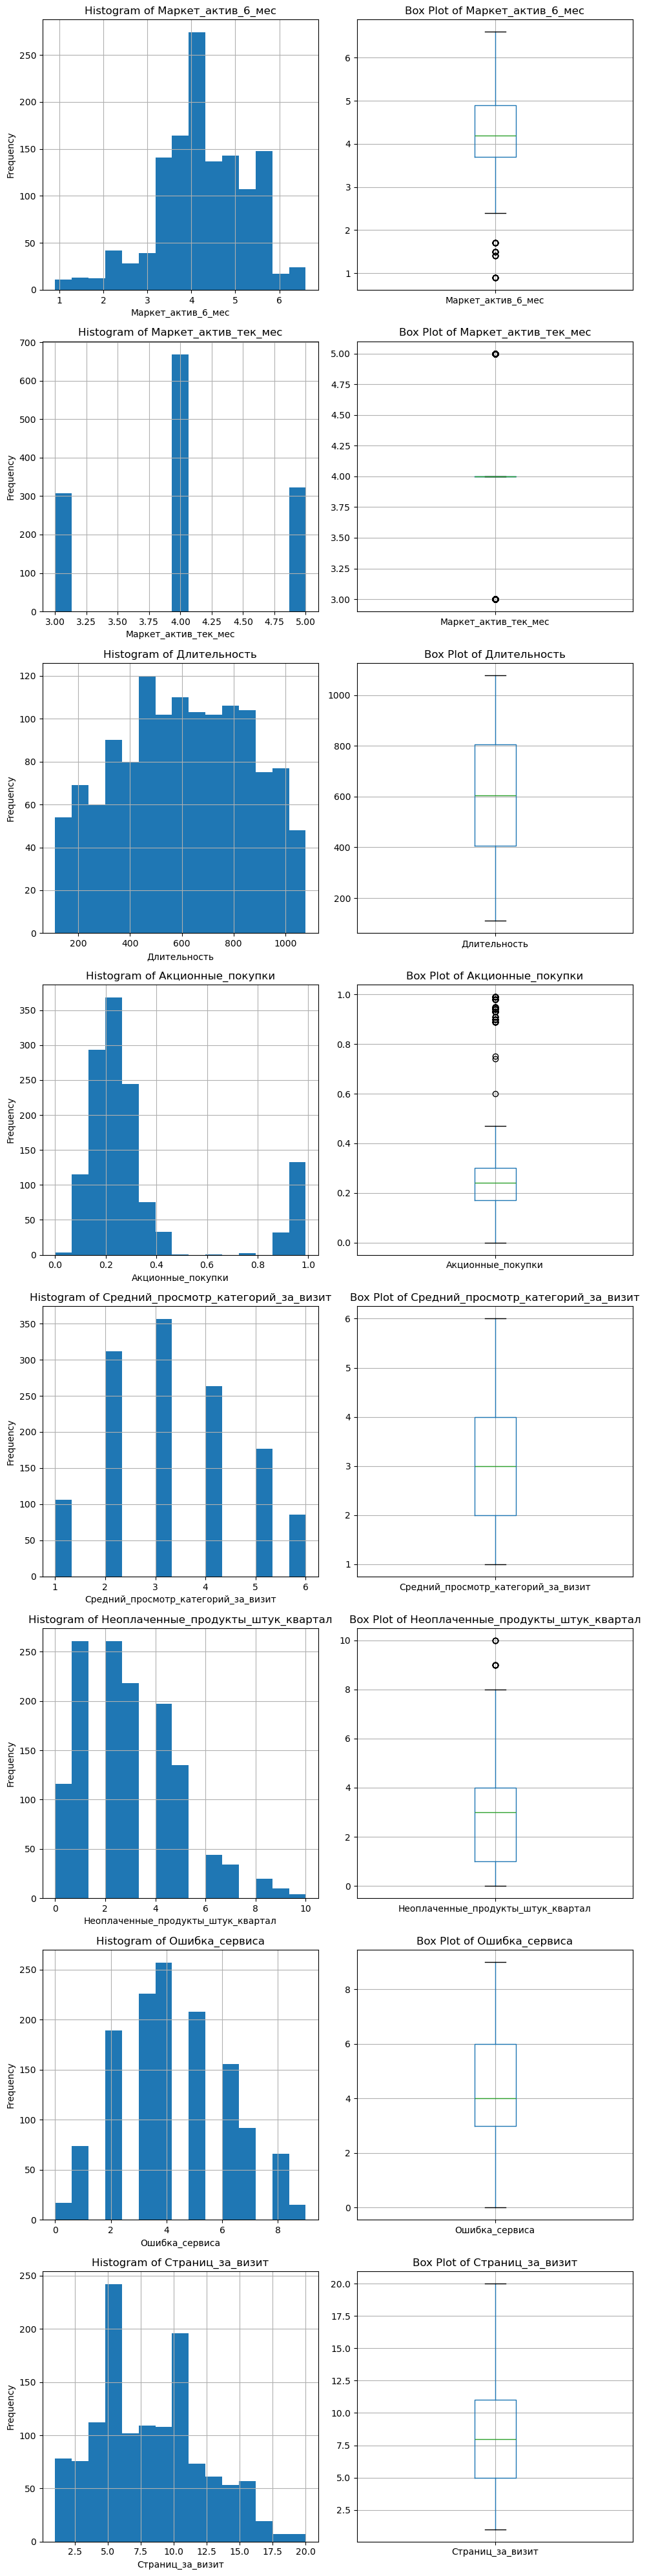

In [41]:
plot_histograms_boxplots(market_file)

Диаграмма для параметра Маркет_актив_тек_мес выглядит так потому что уникальных значений всего 3

In [42]:
market_file['Маркет_актив_тек_мес'].unique()

array([5, 4, 3], dtype=int64)

В параметрах:
- Маркет_актив_6_мес
- Акционные_покупки
- Неоплаченные_продукты_штук_квартал

Присутствуют выбросы. Мы используем разные модели которые умеют с ними работать и они им нужны, поэтому не будем их удалять. Логистическая регрессия, прости сегодня не твой день.

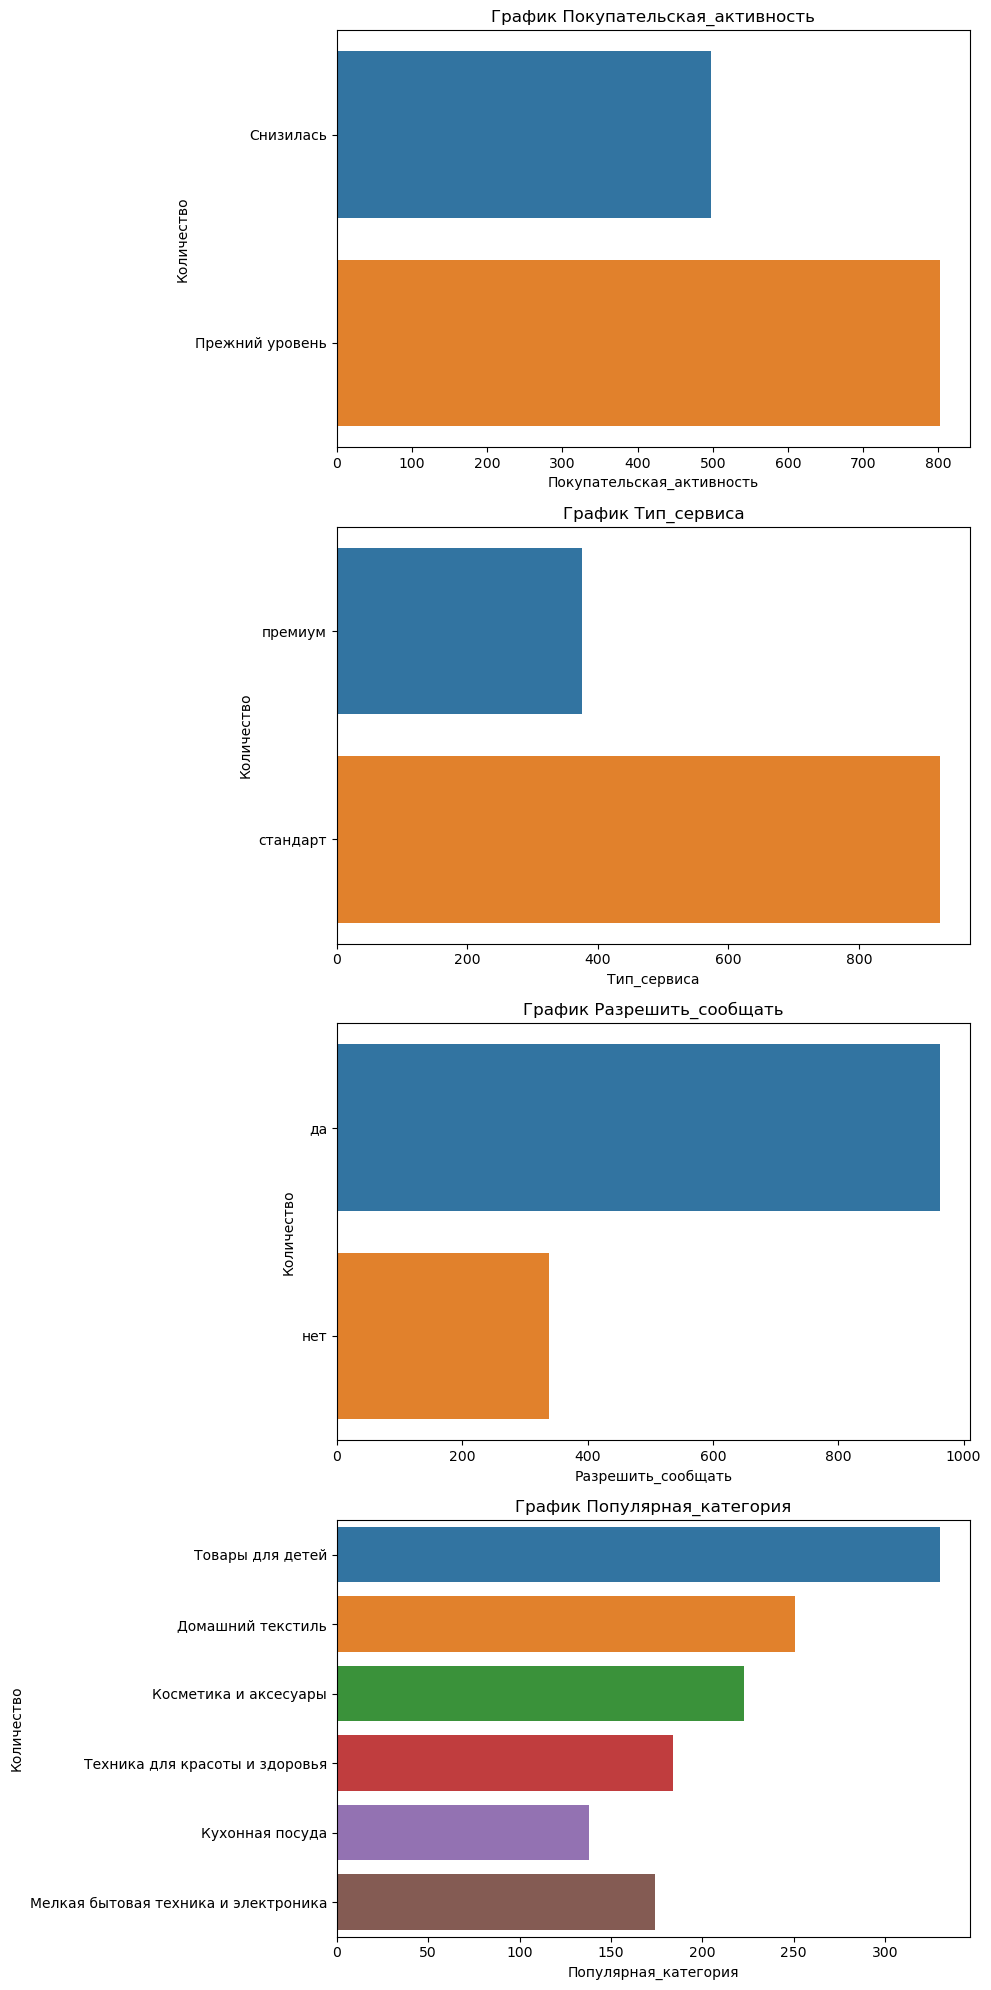

In [43]:
# Изучим распределение
plot_countplots(market_file)

В параметрах: 
- Тип_сервиса 
- Разрешить_сообщать

виден дисбаланс в значениях. Тажке он есть и в целевом признаке Покупательская_активность

#### market_money

In [44]:
market_money.describe()

Выручка
count    3900.000000
mean     5025.696051
std      1777.704104
min         0.000000
25%      4590.150000
50%      4957.500000
75%      5363.000000
max    106862.200000

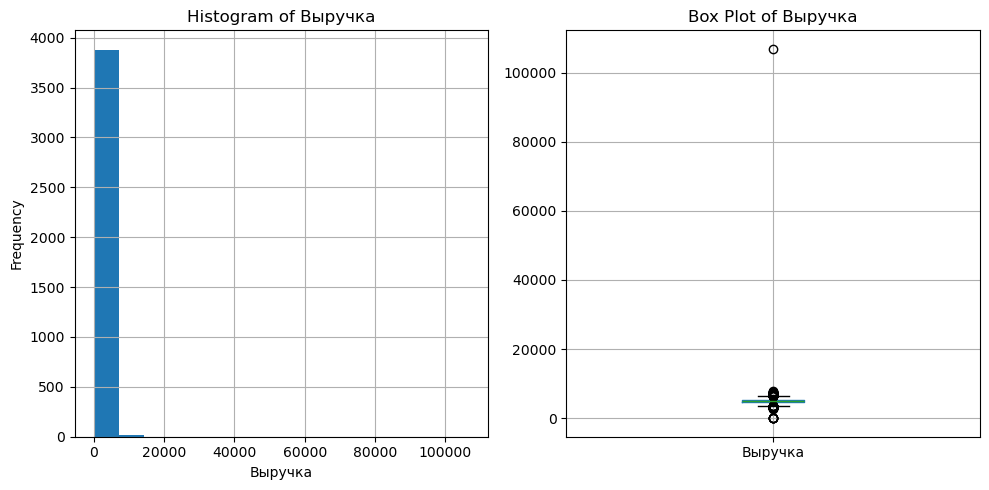

In [45]:
plot_histograms_boxplots(market_money)

In [46]:
#Мы видим анамалию в максимальном значении, найдем и удалим её
market_money.sort_values(by='Выручка', ascending=False).head()

Период   Выручка
id                             
215380  текущий_месяц  106862.2
215493  текущий_месяц    7799.4
215435  текущий_месяц    7605.3
215841  текущий_месяц    7557.0
216144  текущий_месяц    7547.8

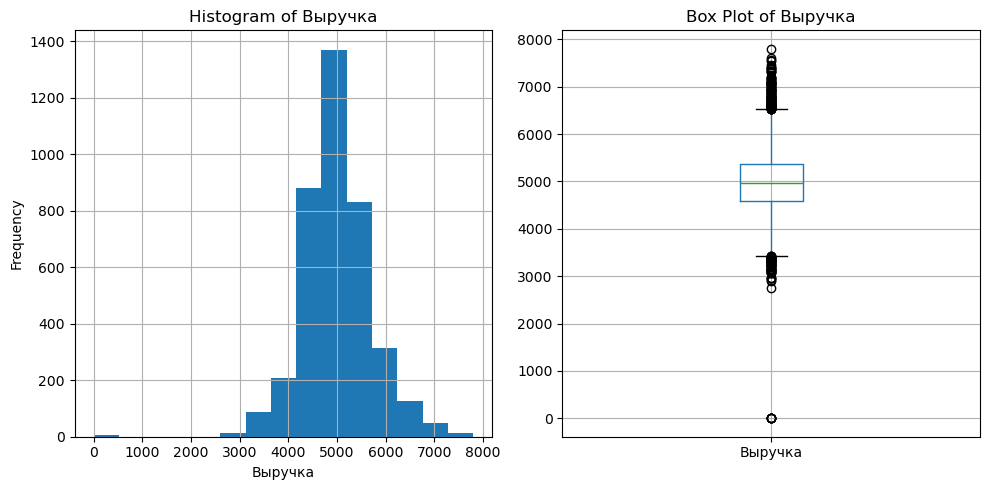

In [47]:
market_money = market_money[market_money['Выручка'] != 106862.2]
plot_histograms_boxplots(market_money)

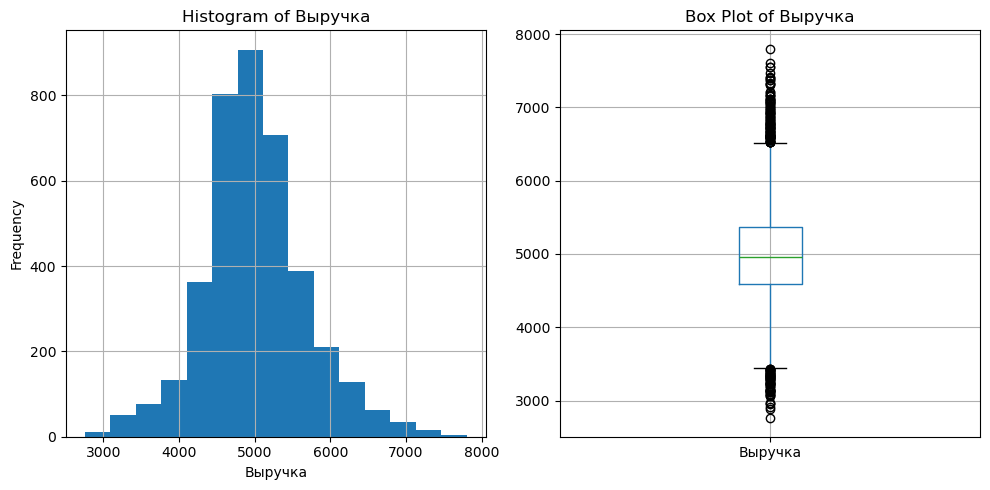

In [48]:
#Значение 0, похоже на анамалию, тоже удаляем
market_money = market_money[market_money['Выручка'] != 0]
plot_histograms_boxplots(market_money)

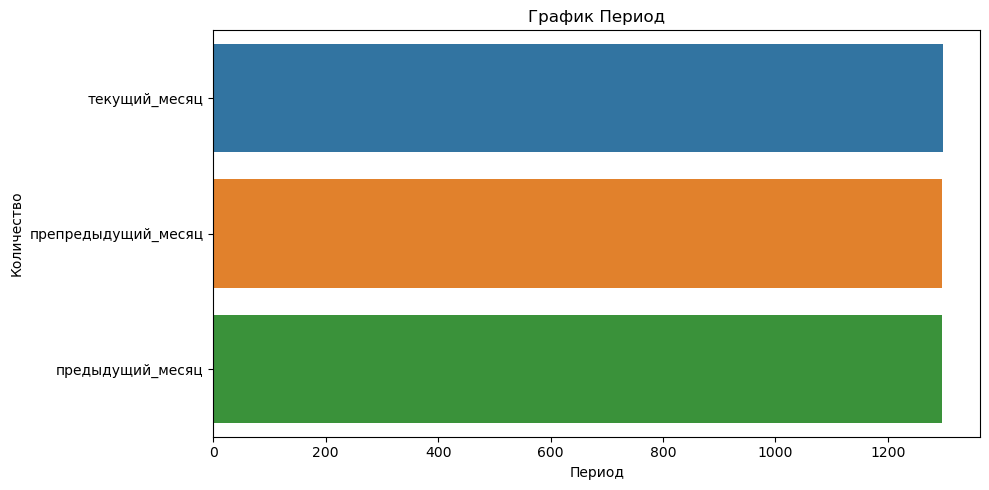

In [49]:
# Изучим распределение
plot_countplots(market_money)

С препредыдущим месяуем стало ещё страннее

#### market_time

In [50]:
market_time.describe()

минут
count  2600.000000
mean     13.336154
std       4.080198
min       4.000000
25%      10.000000
50%      13.000000
75%      16.000000
max      23.000000

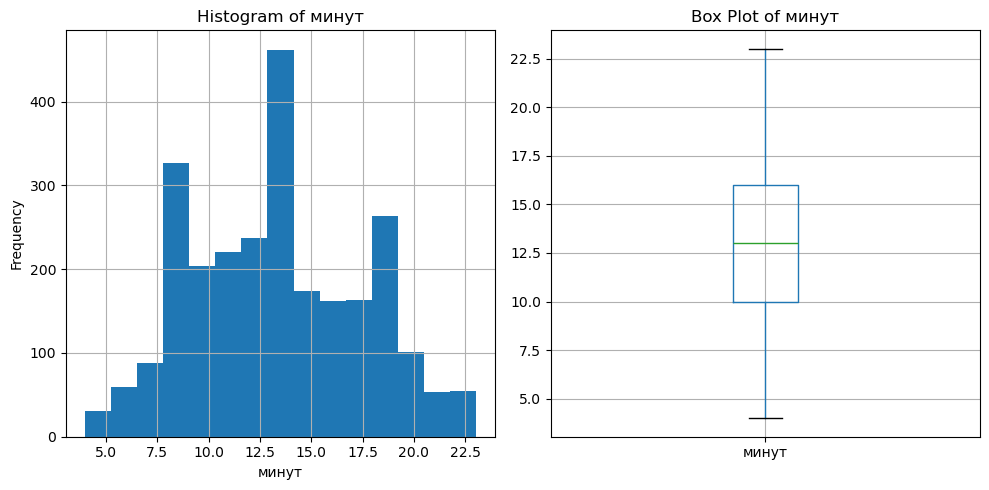

In [51]:
plot_histograms_boxplots(market_time)

В Багдаде всё спокойно

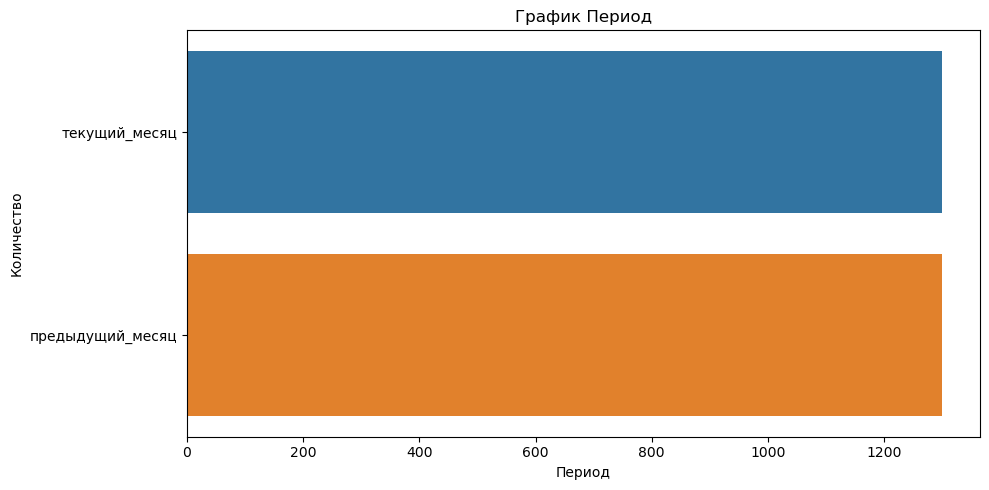

In [52]:
# Изучим распределение
plot_countplots(market_time)

Вы хотите сказать, что в общем пользователи провели на сайте таки одинаковое количество времени?

#### money

In [53]:
money.describe()

Прибыль
count  1300.000000
mean      3.996631
std       1.013722
min       0.860000
25%       3.300000
50%       4.045000
75%       4.670000
max       7.430000

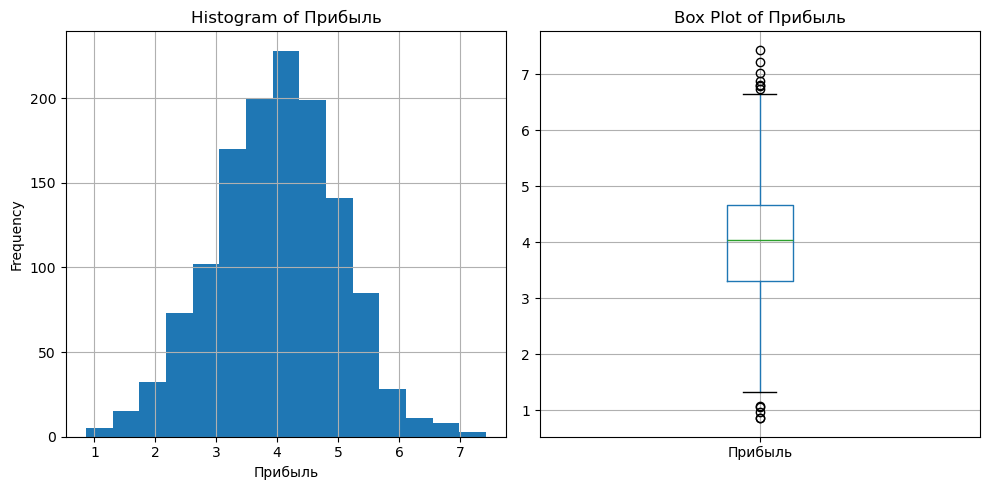

In [54]:
plot_histograms_boxplots(money)

Параметр Прибыль имеет выбросы, но они не далеко, поэтому мы не будем их удалять, что бы не смущать модель.

Для того чтобы отобрать пользователей с покупательской активностью - не менее трёх месяцев, мы возьмём пользователей из таблицы money. Данныя таблица хранит данные о среднемесячной прибыли покупателя за последние 3 месяца. Так как в таблице нет значений равных 0, то все пользователи совершали покупки в течении нужного срока.

In [55]:
market_money[market_money['Выручка']==0].shape

(0, 2)

In [56]:
market_time[market_time['минут']==0].shape

(0, 2)

#### Вывод

Мы наблюдаем в данных  выбросы и неравномерное распределение в общей и целом близкие к нормальному.

### Объединение таблиц
1. Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся. 
2. Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.

Перед тем как объядинять данные явно переименуем столблец Период в таблице market_money на Период_деньги, а Период в таблице market_time на Период_время

In [57]:
market_money.columns

Index(['Период', 'Выручка'], dtype='object')

In [58]:
market_money = market_money.rename(columns={'Период': 'Период_деньги'})
market_money.columns

Index(['Период_деньги', 'Выручка'], dtype='object')

In [59]:
market_time.columns

Index(['Период', 'минут'], dtype='object')

In [60]:
market_time = market_time.rename(columns={'Период': 'Период_время'})
market_time.columns

Index(['Период_время', 'минут'], dtype='object')

#### Вывод:
- Типы в норме
- нет NaN
- уровень тревожности где-то на Тутуине

#### df_money "развернуть" по id, 

In [61]:
market_money = market_money.reset_index()
market_money.head(1)

id  Период_деньги  Выручка
0  215348  текущий_месяц   3293.1

In [62]:
df_money = market_money.pivot(index='id', columns='Период_деньги', values='Выручка')
df_money.head(1)

Период_деньги  предыдущий_месяц  препредыдущий_месяц  текущий_месяц
id                                                                 
215348                      NaN                  NaN         3293.1

In [63]:
df_money.shape

(1300, 3)

In [64]:
df_money = df_money.rename(columns={'предыдущий_месяц': 'предыдущий_месяц_деньги',
                                   'текущий_месяц':'текущий_месяц_деньги',
                                    'препредыдущий_месяц':'препредыдущий_месяц_деньги'
                                   })

In [65]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348 to 216647
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   предыдущий_месяц_деньги     1297 non-null   float64
 1   препредыдущий_месяц_деньги  1297 non-null   float64
 2   текущий_месяц_деньги        1299 non-null   float64
dtypes: float64(3)
memory usage: 40.6 KB


####  df_time "развернуть" по id, 

In [66]:
market_time.head(1)

Период_время  минут
id                          
215348  текущий_месяц     14

In [67]:
market_time = market_time.reset_index()
market_time.head(1)

id   Период_время  минут
0  215348  текущий_месяц     14

In [68]:
df_time = market_time.pivot(index='id', columns='Период_время', values='минут')
df_time.head(1)

Период_время  предыдущий_месяц  текущий_месяц
id                                           
215348                      13             14

In [69]:
df_time = df_time.rename(columns={'предыдущий_месяц': 'предыдущий_месяц_время',
                                   'текущий_месяц':'текущий_месяц_время'                                    
                                   })
df_time.head(1)

Период_время  предыдущий_месяц_время  текущий_месяц_время
id                                                       
215348                            13                   14

#### объединение 2

In [70]:
#объединяем по id
df_full = market_file.merge(df_money, on='id', how='inner')


In [71]:
df_full = df_full.merge(df_time, on='id', how='inner')
df_full.shape

(1300, 17)

In [72]:
df_full = df_full.dropna()
df_full.shape

(1296, 17)

In [73]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            1296 non-null   object 
 1   Тип_сервиса                          1296 non-null   object 
 2   Разрешить_сообщать                   1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Маркет_актив_тек_мес                 1296 non-null   int64  
 5   Длительность                         1296 non-null   int64  
 6   Акционные_покупки                    1296 non-null   float64
 7   Популярная_категория                 1296 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  Ошибка_сервиса                       1296 non-null   int64  
 11  Страниц_за_визит            

## Корреляционный анализ

- Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования.
- Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

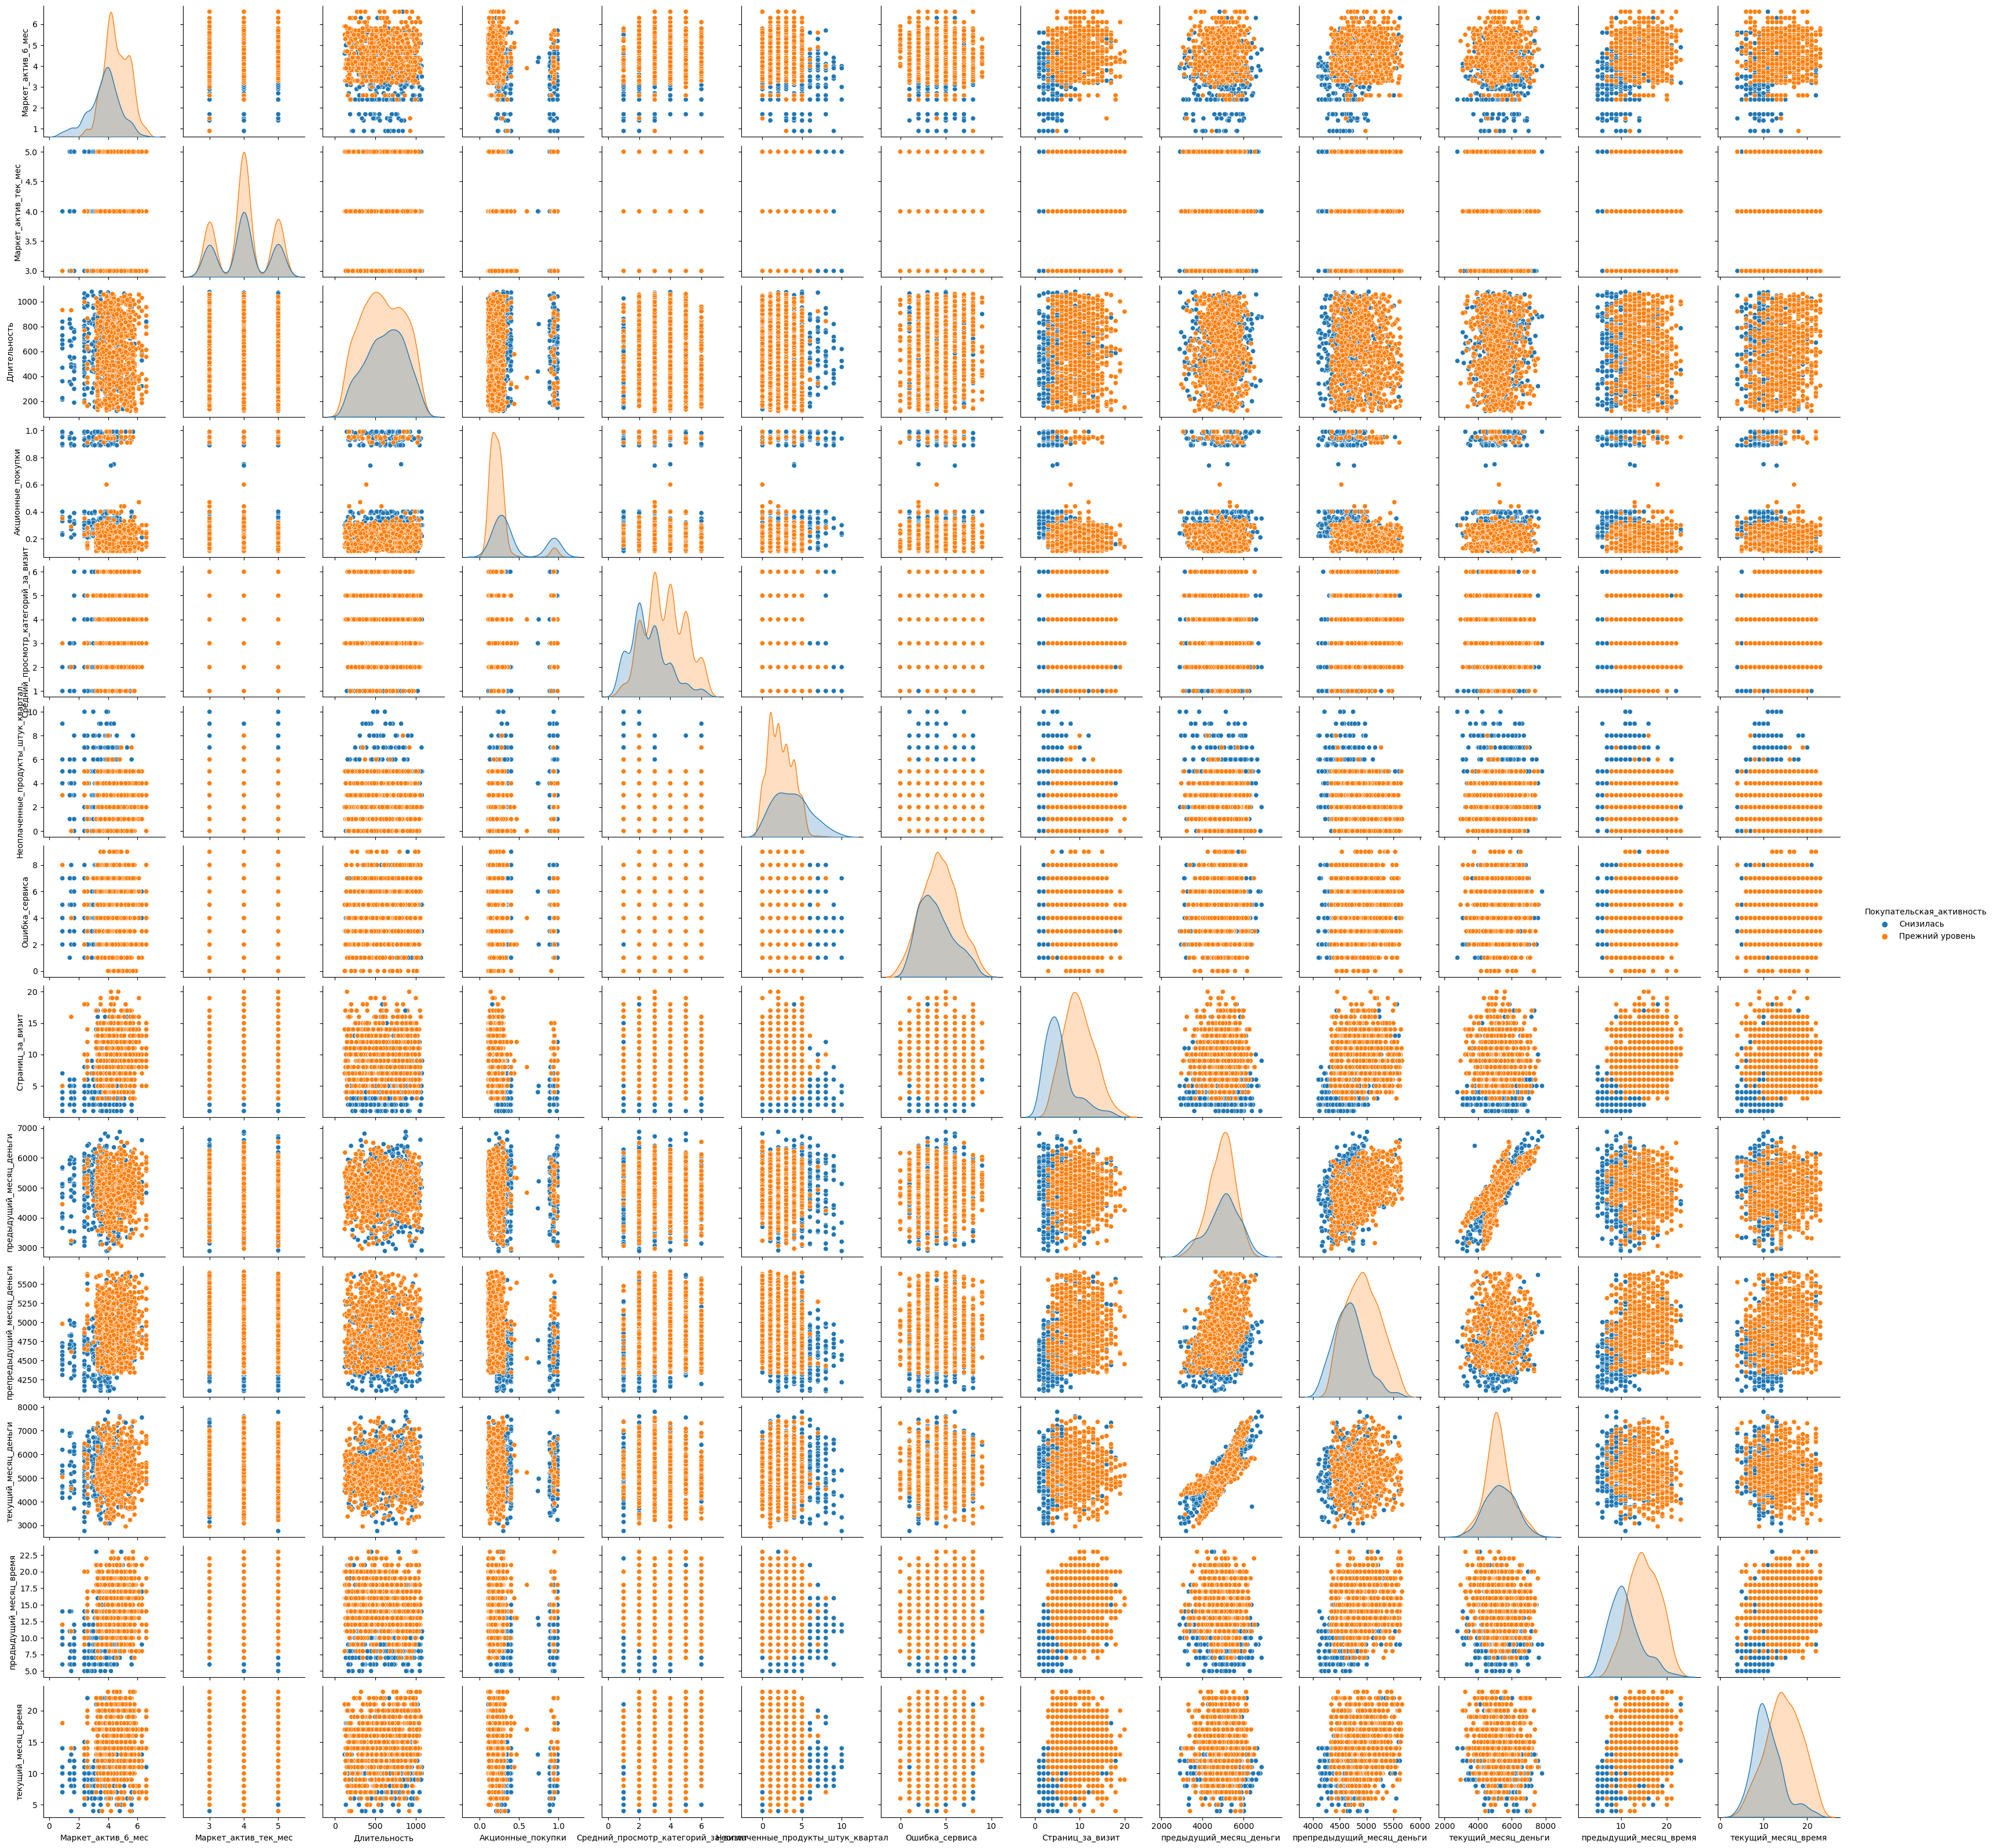

In [74]:
sns.pairplot(df_full, hue='Покупательская_активность')

plt.show()

In [75]:
#numeric_cols = df_full.select_dtypes(include=['number']).columns
#correlation_matrix = df_full[numeric_cols].corr(method='spearman')

#plt.figure(figsize=(10, 8))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
#plt.show()

In [76]:
interval_cols = df_full.select_dtypes(include='number').columns.tolist()

In [77]:
df_full.head(1)

Покупательская_активность Тип_сервиса Разрешить_сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   

        Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
id                                                               
215349                 4.4                     4           819   

        Акционные_покупки Популярная_категория  \
id                                               
215349               0.75     Товары для детей   

        Средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   

        предыдущий_месяц_деньги  препредыдущий_месяц_деньги  \
id                                                            
215349                   5216.0                      4472.0   

        текущий_месяц_деньги  предыдущий_месяц_время  текущий_месяц_время  
id                                                                         
215349                4971.6                      12                   10

#### Снизилась

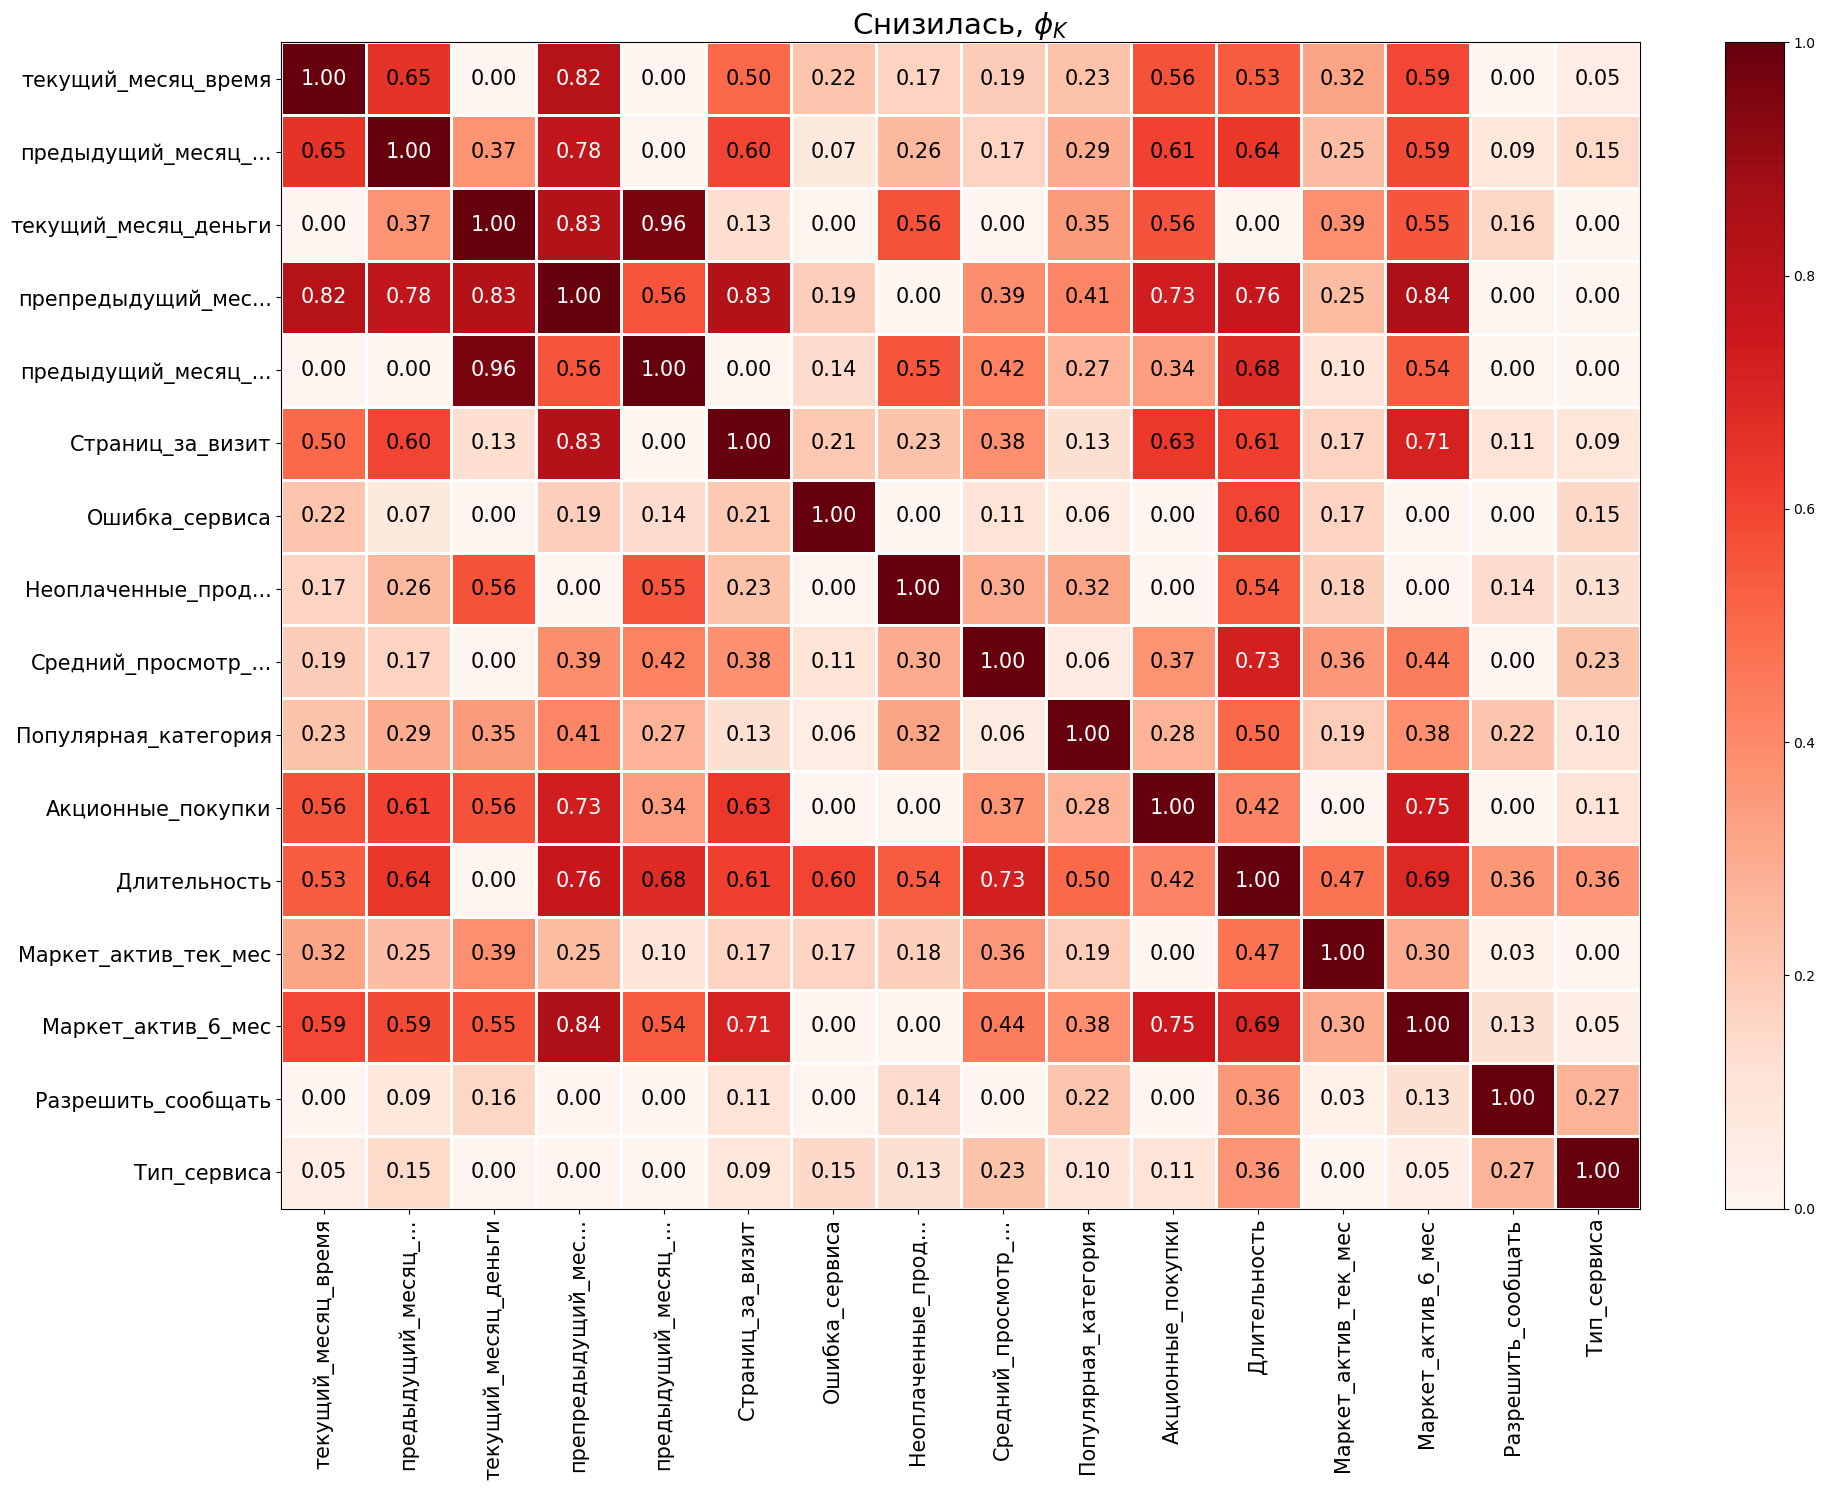

In [78]:
phik_overview_1category = phik_matrix(
    df_full[df_full['Покупательская_активность']=='Снизилась'].drop(['Покупательская_активность'],axis=1),
    interval_cols=interval_cols,
    bins=100
)

plot_correlation_matrix(
    phik_overview_1category.values,
    x_labels=phik_overview_1category.columns,
    y_labels=phik_overview_1category.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Снизилась, $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

#### Прежний уровень

In [ ]:
phik_overview_2category = phik_matrix(
    df_full[df_full['Покупательская_активность']=='Прежний уровень'].drop(['Покупательская_активность'],axis=1),
    interval_cols=interval_cols, bins=100)

plot_correlation_matrix(
    phik_overview_2category.values,
    x_labels=phik_overview_2category.columns,
    y_labels=phik_overview_2category.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'Прежний уровень, $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Мы можем наблюдать, что в обоих есть высокая корреляция только между выручкой за текущий и предыдущей месяцы.
Мы предполагем что в вырочке за текущий месяц данные менее полные, но более актуальные, чем за предыдущий.

Поэтому избавимся от от выручки за предыдущий месяц.

In [ ]:
df_full.info()

In [ ]:
df_full = df_full.drop('предыдущий_месяц_деньги', axis=1)

In [ ]:
df_full.shape

## Использование пайплайнов
- Примените все изученные модели. Для этого используйте пайплайны.<br>
1. Во время подготовки данных используйте ColumnTransformer.
- Количественные и категориальные признаки обработайте в пайплайне раздельно. 
- Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.

*Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.* <br><br>
2. Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC().
- Для каждой из них подберите как минимум один гиперпараметр. 
- Выберите подходящую для задачи метрику, аргументируйте свой выбор.
- Используйте эту метрику при подборе гиперпараметров.

3. Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:
- использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
- использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

In [ ]:
#выделяем целевой признак
X = df_full.drop(['Покупательская_активность'], axis=1)
y = df_full['Покупательская_активность']

#делим выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [ ]:
df_full.columns

In [ ]:
df_full['Тип_сервиса'].unique()

In [ ]:
df_full['Разрешить_сообщать'].unique()

In [ ]:
#Разобьем данные на количественные и категориальные
num_col_names = df_full.select_dtypes(include='number').columns.tolist()
ohe_col_names = df_full.select_dtypes(exclude='number').drop(
     ['Покупательская_активность'], axis=1
).columns.tolist()

#добавили два в орд и убрали их из ohe
ord_columns = ['Тип_сервиса', 'Разрешить_сообщать']


In [ ]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'], 
                    ['нет', 'да'],
                    
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [ ]:
#Создадим пайплайн для OneHotEncoder
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [ ]:
# создаём общий пайплайн для подготовки данных 1
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_col_names),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_col_names)
], remainder='passthrough')

#### выбор метрики

- F1-мера — это метрика качества классификации, которая показывает среднее гармоническое между precision и recall. Её нужно использовать, когда вам важны результаты обеих исходных метрик. Оценивают работу модели по её результатам.
- ROC-AUC — это всеохватывающая метрика качества классификации. Она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного. Оценивает способность модели различать между классами.

*(с) Яндекс практикум*

Мы считаем что текущая задача с разделением классов, а не со способностю модели правильно классифицировать положительные и отрицательные примеры, поэтому ROC-AUC является более подходящей метрикой.

In [ ]:
# создаём итоговый пайплайн: подготовка данных и модель 2
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 120),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1.0, 10.0, 100.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    # словарь для модели SVC()
    {
        'models': [SVC(probability=True)],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

In [ ]:
y_test.head()

#### Вывод_old:
Метод k-ближайших соседей с учётом 6 ближайших подозрительно хорош, но не идеален. Мы молодцы в том, что не заморачивались с выбросами.

#### Вывод_new:
Метод k-ближайших соседей с учётом 70 ближайших подозрительно хорош, но не идеален. Мы молодцы.

## Анализ важности признаков
1. Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 
2. Сделайте выводы о значимости признаков:
- какие признаки мало значимы для модели;
- какие признаки сильнее всего влияют на целевой признак;
- как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

In [ ]:
COUNT = 10
 
# Извлечение лучшей модели из результатов RandomizedSearchCV
best_model = randomized_search.best_estimator_.named_steps['models']

# Предобработка данных через пайплайн без конечной модели
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Получаем имена признаков после OneHotEncoder
ohe_feature_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features=ohe_col_names)

# Для OrdinalEncoder и StandardScaler мы можем использовать имена как есть
num_feature_names = num_col_names

# Объединяем все имена признаков в один список
#all_feature_names = np.concatenate([ohe_feature_names, num_feature_names])
all_feature_names = preprocessor.get_feature_names_out().tolist()

# Создаем DataFrame с соответствующими именами колонок
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

# Семпл данных для KernelExplainer
X_train_preprocessed_smpl = shap.sample(X_train_preprocessed_df, COUNT, random_state=RANDOM_STATE)
X_test_preprocessed_smpl = shap.sample(X_test_preprocessed_df, COUNT, random_state=RANDOM_STATE)

# Теперь, когда у нас есть DataFrame с именами признаков, мы можем использовать KernelExplainer
explainer = shap.KernelExplainer(best_model.predict_proba, X_train_preprocessed_smpl)
shap_values = explainer.shap_values(X_test_preprocessed_smpl)

# Построение графика с именами признаков
shap.summary_plot(shap_values[:, :, 1], X_test_preprocessed_smpl)

#### Вывод
- Высокое значение акционных покупок показывают повышение вероятности принадлежности пользователя к классу 1 - Прежний уровень покупательской активности.
- Высокое значение Времени в текущем и предыдущем месяце, Страниц_за_визит показывают понижение вероятности принадлежности пользователя к классу 1


## Сегментация покупателей
1. Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.
2. Выберите группу покупателей и предложите, как увеличить её покупательскую активность:
- Проведите графическое и аналитическое исследование группы покупателей
- Сделайте предложения по работе с сегментом для увеличения покупательской активности
3. Сделайте выводы о сегментах:
- какой сегмент вы взяли для дополнительного исследования
- какие предложения вы сделали и почему

In [ ]:
# Чтобы наверника
threshold = 0.9
'''
8.1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

'''
#Применим модель для всех данных
best_model = randomized_search.best_estimator_
predictions = best_model.predict_proba(X)[:, 1]
prediction_flags = np.where(predictions > threshold, True, False)

df_decline = df_full
df_decline['flag'] = prediction_flags

In [ ]:
# Выберем только те данные для которых модель предсказала снижение
df_decline = df_full.loc[prediction_flags]

#df_decline = df_full
#df_decline['вероятность_снижения'] = predictions

# Добавить в эти данные инфу о прибыльности из таблицы money
df_decline = df_decline.join(money, on='id')

# Проверим что появился столбец
df_decline.info()

In [ ]:
df_all = df_full.join(money, on='id')

In [ ]:
df_all['Прибыль'].describe()

In [ ]:
df_decline['Прибыль'].describe()

In [ ]:
df_decline['Акционные_покупки'].value_counts(bins=10)

In [ ]:
df_decline.shape

In [ ]:
'''
8.1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

'''
threshold_money = (df_decline['Прибыль'] > 3)
df_decline = df_decline.loc[threshold_money]
#наш сегмент
df_decline.shape

In [ ]:
#датафрейм без сигмента
df_all.drop(df_decline.index, inplace=True)
df_all.shape


Сравнение покупателей из сегмента с остальными, по наиболее влиятельным категориям. 
 У нас есть уже список параметров которые влияют на покупательскую активности. 
- количество акционных покупок - повышает
- Времени в текущем и предыдущем месяце, а так же Страниц_за_визит - понижают.



In [ ]:
def hist_8(df_all, segment, cat):
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=df_all[cat],  name='Остальные', histnorm = 'probability', opacity=0.75))
    fig.add_trace(go.Histogram(x=segment[cat],  name='Сегмент', histnorm = 'probability', opacity=0.75))


    fig.update_layout(
        title="Гистограммы на основе " + cat ,
        title_x = 0.5,
        xaxis_title=cat,
        yaxis_title="Количество пользователей",
        legend=dict(x=.5, xanchor="center", orientation="h"),
        barmode='overlay',
        margin=dict(l=0, r=0, t=30, b=0)
    )

    fig.show()

In [ ]:
hist_8(df_all, df_decline, 'Акционные_покупки')

In [ ]:
hist_8(df_all, df_decline, 'предыдущий_месяц_время')

In [ ]:
hist_8(df_all, df_decline, 'текущий_месяц_время')

In [ ]:
hist_8(df_all, df_decline, 'Средний_просмотр_категорий_за_визит')

In [ ]:
hist_8(df_all, df_decline, 'Неоплаченные_продукты_штук_квартал')

In [ ]:
df_decline.columns

**Признаки, больше всего связанные с активностью клиентов:**
- Число страниц за визит;
- Времяпровождение в текущем и предыдущем месяцах;
- Количество просмотренных категорий в среднем.

In [ ]:
'''
8.2 Выберите группу покупателей и предложите, как увеличить её покупательскую активность:
     - Проведите графическое и аналитическое исследование группы покупателей
     - Сделайте предложения по работе с сегментом для увеличения покупательской активности
 У нас есть уже список параметров которые влияют на снижение покупательской активности. 
 Возьмем первые 5 и выделим группу на основе них
 Акционные_покупки, минут, Страниц_за_визит, Средний_просмотр_категорий_за_визит, Популярная_категория
'''


plt.figure(figsize=(21, 7))

plt.subplot(1, 3, 1)
sns.histplot(df_decline['Акционные_покупки'], bins=10)
plt.title('Акционные покупки')

plt.subplot(1, 3, 2)
sns.histplot(df_decline['предыдущий_месяц_время'], bins=10)
plt.title('Минут')

plt.subplot(1, 3, 3)
sns.histplot(df_decline['текущий_месяц_время'], bins=20)
plt.title('Минут')

plt.tight_layout()
plt.show()

In [ ]:

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.histplot(df_decline['Средний_просмотр_категорий_за_визит'], bins=10)
plt.title('Средний просмотр категорий за визит')

plt.subplot(1, 2, 2)
sns.histplot(df_decline['Страниц_за_визит'], bins=10)
plt.title('Страниц за визит')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Мы взяли сегмент покупателей с теми параметрами, которые сильнее всего влияют на снижение покупательской активности. <br>

На графиках видны следующие закономености:
- Время проведенные на сайте, стрниц за визит и просмотр категорий ниже нормального распередения.
- Виден выброс на графике с акционными товарами

**Активность пользователя снизится, если:**

- среднее число просмотренных категорий за визит очень маленькое;
- маленькое количество просмотренных страниц за визит;
- в целом небольшое времяпровождение на сайте;

### Общий вывод
В начале проекта были поставлены следующие задачи:

1. Построить модель для предсказания снижения покупательской активноски
2. Используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения. <br>
В качестве данных были предоставлены 4 таблицы

market_file.csv. Таблица с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
market_money.csv. Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
market_time.csv. Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
money.csv. Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.<br>
Для посика лучшей модели были проделаны следующие шаги

1. изучены данные
2. обработаны пропуски и дубликаты
3. исследованы на качество, проверены на выбросы и аномалии
4. исследованы взаимосвязи количественных признаков с помощью корреляционного анализа
5. объединены данные чтобы у модели были больше признаков для обучения
6. настроенна автоматизация обучения с помощью пайпдайнов, в которых были обучены 2 типа моделей: линейные и на основе векторов
7. лучшая модель оказалась KNeighborsClassifier <br>
На основе выбранной модели был построен график с параметрами, которые сильнее всего влияют предсказание. На основе этих параметров был сделан вывод: <br><br> 

что при снижении покупательской активности стоит акцентировать внимание пользователей на акционные товары в самых просматриваемых категориях.